In [14]:
import numpy as np
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


### Asi voy a dividir entre train y test para mi validacion

In [15]:
def mi_split (df):

    X = df.drop(['precio'], axis = 1)

    Y = df['precio']

    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    
    return x_train, x_test, y_train, y_test

# x_train y_train son mi TRAIN
# x_test y_test son mi VALIDACION

### .....................................................................................................................

### <b> Modelo N°1 - KNN </b>

In [16]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [22]:
# Uso lo mas que puedo del train (Saco precio <obvio> y las que no son numéricas)
# Ademas, debo tirar los NaNs
# Todas éstas, son restricciones de KNN

trainKNN = train.dropna()
trainKNN = trainKNN.drop(['descripcion', 'titulo', 'tipodepropiedad', 'direccion', 
                          'provincia', 'ciudad', 'fecha'], axis=1)

x_train, x_test, y_train, y_test = mi_split(trainKNN)

mae_obtenido = []

for K in range(20):
    
    K = K+1
    neigh = KNeighborsRegressor(n_neighbors = K)       #Crea modelo
    neigh.fit(x_train, y_train)                        #Fitea al train
    prediccion = neigh.predict(x_test)                 #Predice el test
    errorMAE = mean_absolute_error(y_test,prediccion)  #Calcula MAE
    mae_obtenido.append(errorMAE)                      #Guarda valor de MAE

In [37]:
mae_obtenido[6]

1165871.1855696673

Text(0, 0.5, 'MAE')

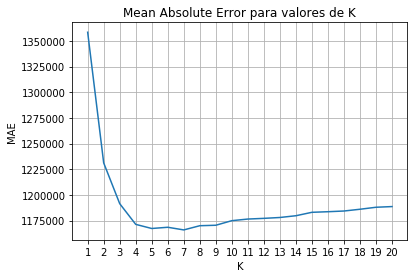

In [26]:
k_utilizado = np.arange(20)+1

ax = plt.plot(k_utilizado, mae_obtenido)
plt.grid()
plt.xticks(k_utilizado)
plt.title("Mean Absolute Error para valores de K")
plt.xlabel("K")
plt.ylabel("MAE")

#### Veo cual es el mínimo resultado

In [44]:
np.min(mae_obtenido)

1165871.1855696673

In [45]:
mae_obtenido[6]  #En realidad es MAE (k = 7) pues arranca a contar en 1

1165871.1855696673

#### Me quedo con el mejor para este modelo

### <mark> KNN (k=7) - MAE: 1.165.871,18 </mark>

### ...................................................................................................................................

### <b> Modelo N°2 - XGBoost </b>

In [58]:
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [59]:
#Nuevamente tengo restricciones, debo borrar los features que no sean numéricas

trainXGB = train.drop(['descripcion', 'titulo', 'tipodepropiedad', 'direccion', 
                      'provincia', 'ciudad', 'fecha'], axis = 1)

x_train, x_test, y_train, y_test = mi_split(trainXGB)


xgb_model = xgb.XGBRegressor(objective="reg:squarederror")  #Crea Modelo
xgb_model.fit(x_train, y_train)                             #Fitea Modelo
prediccion = xgb_model.predict(x_test)                      #Predice Test
mae = mean_absolute_error(y_test, prediccion)               #Mide MAE
print("Promedio de error absoluto obtenido: " + str(mae))

/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Promedio de error absoluto obtenido: 822878.428889272


### <mark> XGB POR DEFECTO - MAE: 822.878,43 </mark>

##### (Todo esto fue por defecto, ahora empiezo a ajustar hiperparámetros)

#### BUSQUEDA DE HIPERPARAMETROS

In [60]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [61]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            random_state=42, n_iter=5, cv=3, verbose=1, n_jobs=1, 
                            return_train_score=True)

search.fit(x_train, y_train)

report_best_scores(search.cv_results_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base

Model with rank: 1
Mean validation score: 0.742 (std: 0.002)
Parameters: {'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}

Model with rank: 2
Mean validation score: 0.736 (std: 0.002)
Parameters: {'colsample_bytree': 0.7550213529560301, 'gamma': 0.15212112147976886, 'learning_rate': 0.18742692948967135, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.7164916560792167}

Model with rank: 3
Mean validation score: 0.725 (std: 0.001)
Parameters: {'colsample_bytree': 0.8835558684167137, 'gamma': 0.06974693032602092, 'learning_rate': 0.11764339456056544, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.7824279936868144}



#### UTILIZO MEJOR RESULTADO DEL RANDOM SEARCH

In [62]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree = 0.7467983561008608,
                             gamma = 0.02904180608409973,
                             learning_rate = 0.28985284373248055,
                             max_depth = 5,
                             n_estimators = 139,
                             subsample = 0.8832290311184181,
                             eval_metric = "mae") #Que es la que se usa en la competencia

xgb_model.fit(x_train,y_train)                           # Fiteo

prediccion = xgb_model.predict(x_test)                   # Predigo

mae = mean_absolute_error(y_test, prediccion)            # Calculo Error

print("Promedio de error absoluto obtenido: " + str(mae))

Promedio de error absoluto obtenido: 678932.1940552419


### <mark> XGB TUNEADO - MAE: 678.932,19 </mark>

#### Vemos como tras el tuning, logramos reducir el MAE respecto del XGB con los hiperparámetros por defecto

### .............................................................................................................................

### <b> Modelo N°2b - XGBoost con valores numericos arbitrarios</b>

##### Lo que me propongo hacer ahora, es poder utilizar los valores categóricos de tipo_de_propiedad, para ello, le voy a asignar un valor numérico a cada una de ellas

#### ASIGNO VALOR NUMERICO A LOS TIPOS DE PROPIEDAD

In [71]:
def f (tipo):
    
    if tipo == "Apartamento": 
        return 1

    if tipo == "Bodega comercial": 
        return 2

    if tipo == "Casa en condominio": 
        return 3

    if tipo == "Casa uso de suelo": 
        return 4

    if tipo == "Departamento Compartido": 
        return 5

    if tipo == "Duplex": 
        return 6

    if tipo == "Edificio": 
        return 7

    if tipo == "Garage": 
        return 8

    if tipo == "Hospedaje": 
        return 9

    if tipo == "Huerta": 
        return 10

    if tipo == "Inmuebles productivos urbanos": 
        return 11

    if tipo == "Local Comercial": 
        return 12
    
    if tipo == "Local en centro comercial": 
        return 13

    if tipo == "Lote": 
        return 14
    
    if tipo == "Nave industrial": 
        return 15

    if tipo == "Oficina comercial": 
        return 16
    
    if tipo == "Otros": 
        return 17

    if tipo == "Quinta Vacacional": 
        return 18
    
    if tipo == "Rancho": 
        return 19
    
    if tipo == "Terreno": 
        return 20
    
    if tipo == "Terreno industrial": 
        return 21
    
    if tipo == "Villa": 
        return 22
    
    else: return 0

train['tipodepropiedad'] = train['tipodepropiedad'].apply(f)

In [73]:
trainXGB2b = train.drop(['descripcion', 'titulo', 'ciudad', 'direccion', 
                         'provincia', 'fecha'], axis = 1)

x_train, x_test, y_train, y_test = mi_split(trainXGB2b)

#### REPITO BUSQUEDA DE HIPERPARAMETROS

In [74]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [75]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            random_state=42, n_iter=5, cv=3, verbose=1, n_jobs=1, 
                            return_train_score=True)

search.fit(x_train, y_train)

report_best_scores(search.cv_results_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base

Model with rank: 1
Mean validation score: 0.739 (std: 0.003)
Parameters: {'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}

Model with rank: 2
Mean validation score: 0.733 (std: 0.003)
Parameters: {'colsample_bytree': 0.7550213529560301, 'gamma': 0.15212112147976886, 'learning_rate': 0.18742692948967135, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.7164916560792167}

Model with rank: 3
Mean validation score: 0.725 (std: 0.002)
Parameters: {'colsample_bytree': 0.8835558684167137, 'gamma': 0.06974693032602092, 'learning_rate': 0.11764339456056544, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.7824279936868144}



#### UTILIZO MEJOR RESULTADO DEL RANDOM SEARCH

In [76]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree = 0.7467983561008608,
                             gamma = 0.02904180608409973,
                             learning_rate = 0.28985284373248055,
                             max_depth = 5,
                             n_estimators = 139,
                             subsample = 0.8832290311184181,
                             eval_metric = "mae") #Que es la que se usa en la competencia


xgb_model.fit(x_train,y_train)                           # Fiteo

prediccion = xgb_model.predict(x_test)                   # Predigo

mae = mean_absolute_error(y_test, prediccion)            # Calculo Error

print("Promedio de error absoluto obtenido: " + str(mae))

Promedio de error absoluto obtenido: 673741.9394309565


### <mark> XGB TUNEADO - MAE: 673.741,94 </mark>

#### APLICO UN TUNING UN POCO MAS PROFUNDO

In [9]:
params = {
    
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.02, 0.3), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(100, 160), # default 100
    "subsample": uniform(0.6, 0.4)
}


xgb_model = xgb.XGBRegressor()

search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            random_state=12, n_iter=10, cv=4, verbose=1, n_jobs=1, 
                            return_train_score=True)

search.fit(x_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[20:21:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:21:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:22:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:22:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:23:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:23:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:25:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:25:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:26:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:26:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:26:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:27:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:27:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:28:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:28:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:28:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:28:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:29:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:29:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:30:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:30:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:30:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:31:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:32:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:33:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:34:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:34:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:35:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:35:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:37:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:38:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:39:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:40:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:41:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:42:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 21.5min finished
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:42:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model with rank: 1
Mean validation score: 0.771 (std: 0.001)
Parameters: {'colsample_bytree': 0.7982708428790268, 'gamma': 0.1673237645530279, 'learning_rate': 0.3134174237049557, 'max_depth': 7, 'n_estimators': 151, 'subsample': 0.9801254098798101}



#### USO MEJOR RESULTADO DEL RANDOM SEARCH

In [77]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree = 0.7982708428790268,
                             gamma = 0.1673237645530279,
                             learning_rate = 0.3134174237049557,
                             max_depth = 7,
                             n_estimators = 151,
                             subsample = 0.9801254098798101,
                             eval_metric = "mae") #Que es la que se usa en la competencia


xgb_model.fit(x_train,y_train)                           # Fiteo

prediccion = xgb_model.predict(x_test)                   # Predigo

mae = mean_absolute_error(y_test, prediccion)            # Calculo Error

print("Promedio de error absoluto obtenido: " + str(mae))

/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Promedio de error absoluto obtenido: 646234.750878596


### <mark> XGB TUNEADO - MAE: 646.234,75 </mark>

#### ...................................................................................................................................................................

### <b> Modelo N°2c - XGBoost c/ valores numericos ponderados x precio promedio</b> 

#### La idea es darle valor numerico a tipo_de_propiedad y a provincia (proximamente de ser posible tambien a ciudad, de manera que su valor sea representativo del precio promedio de una propiedad para esa categoría, por ejemplo, como "DF" es la provincia más cara, llevará el valor mas alto, y como "Baja California Norte" es la más barata, llevará el valor mas bajo. Éste análisis, fue el realizado en el TP1

In [78]:
def valorizar_provincia (tipo):
    
    if tipo == "Baja California Norte": 
        return 1

    if tipo == "Tlaxcala": 
        return 2

    if tipo == "Durango": 
        return 3

    if tipo == "Baja California Sur": 
        return 4

    if tipo == "Hidalgo": 
        return 5

    if tipo == "Nayarit": 
        return 6

    if tipo == "Zacatecas": 
        return 7

    if tipo == "Aguascalientes": 
        return 8

    if tipo == "Michoacán": 
        return 9

    if tipo == "Sonora": 
        return 10

    if tipo == "Coahuila": 
        return 11

    if tipo == "Colima": 
        return 12
    
    if tipo == "Campeche": 
        return 13

    if tipo == "Oaxaca": 
        return 14
    
    if tipo == "Tamaulipas": 
        return 15

    if tipo == "Sinaloa": 
        return 16
    
    if tipo == "Chihuahua": 
        return 17

    if tipo == "Guanajuato": 
        return 18
    
    if tipo == "Veracruz": 
        return 19
    
    if tipo == "San luis Potosí": 
        return 20
    
    if tipo == "Chiapas": 
        return 21
    
    if tipo == "Yucatán": 
        return 22
    
    if tipo == "Querétaro": 
        return 22
    
    if tipo == "Morelos": 
        return 23
    
    if tipo == "Puebla": 
        return 24
    
    if tipo == "Tabasco": 
        return 25
    
    if tipo == "Jalisco": 
        return 26
    
    if tipo == "Quintana Roo": 
        return 27
    
    if tipo == "Guerrero": 
        return 28
    
    if tipo == "Nuevo León": 
        return 29
    
    if tipo == "Edo. de México": 
        return 30
    
    if tipo == "Distrito Federal": 
        return 31

    else: return 0

In [79]:
def valorizar_tipo_propiedad (tipo):
    
    if tipo == "Garage": 
        return 1

    if tipo == "Lote": 
        return 2

    if tipo == "Duplex": 
        return 3

    if tipo == "Terreno": 
        return 4

    if tipo == "Local en centro comercial": 
        return 5

    if tipo == "Local Comercial": 
        return 6

    if tipo == "Casa": 
        return 7

    if tipo == "Terreno comercial": 
        return 8

    if tipo == "Departamento Compartido": 
        return 9

    if tipo == "Bodega comercial": 
        return 10

    if tipo == "Apartamento": 
        return 11

    if tipo == "Villa": 
        return 12
    
    if tipo == "Otros": 
        return 13

    if tipo == "Casa en condominio": 
        return 14
    
    if tipo == "Hospedaje": 
        return 15

    if tipo == "Oficina comercial": 
        return 16
    
    if tipo == "Quinta Vacacional": 
        return 17

    if tipo == "Huerta": 
        return 18
    
    if tipo == "Terreno industrial": 
        return 19
    
    if tipo == "Casa uso de suelo": 
        return 20
    
    if tipo == "Nave industrial": 
        return 21
    
    if tipo == "Inmuebles productivos urbanos": 
        return 22

    if tipo == "Rancho": 
        return 23

    if tipo == "Edificio": 
        return 24
    
    else: return 0

In [82]:
#Valorizo tipo de propiedad del anuncio
train['tipodepropiedad'] = train['tipodepropiedad'].apply(valorizar_tipo_propiedad)

#Valorizo provincia del anuncio
train['provincia'] = train['provincia'].apply(valorizar_provincia)

#Armo mi nuevo train
trainXGB2c = train.drop(['descripcion', 'titulo', 'ciudad', 'direccion', 'fecha'], axis = 1)
x_train, x_test, y_train, y_test = mi_split(trainXGB2c)

#### BUSQUEDA EXHAUSTIVA DE HIPERPARAMETROS

In [7]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [8]:
params = {
    
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.02, 0.3), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(100, 160), # default 100
    "subsample": uniform(0.6, 0.4)
}


xgb_model = xgb.XGBRegressor()

search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            random_state=12, n_iter=10, cv=4, verbose=1, n_jobs=1, 
                            return_train_score=True)

search.fit(x_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:14:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:15:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:15:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:16:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:16:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:17:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:17:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:18:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:19:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:19:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:20:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:20:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:21:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:21:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:22:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:22:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:23:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:23:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:24:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:24:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:24:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:25:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:25:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:26:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:27:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:29:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:30:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:31:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:31:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:32:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:32:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:32:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:33:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:34:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:35:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:36:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:36:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:37:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:38:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 25.1min finished
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:39:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model with rank: 1
Mean validation score: 0.781 (std: 0.002)
Parameters: {'colsample_bytree': 0.7982708428790268, 'gamma': 0.1673237645530279, 'learning_rate': 0.3134174237049557, 'max_depth': 7, 'n_estimators': 151, 'subsample': 0.9801254098798101}



In [83]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree = 0.7982708428790268,
                             gamma = 0.1673237645530279,
                             learning_rate = 0.3134174237049557,
                             max_depth = 7,
                             n_estimators = 151,
                             subsample = 0.9801254098798101,
                             eval_metric = "mae") #Que es la que se usa en la competencia

xgb_model.fit(x_train,y_train)

prediccion = xgb_model.predict(x_test)

mae = mean_absolute_error(y_test, prediccion)

print("Promedio de error absoluto obtenido: " + str(mae))

Promedio de error absoluto obtenido: 644493.2091361898


### <mark> XGB TUNEADO - MAE: 644.493,21 </mark>

### .................................................................................................................................

### <b> Modelo N°2d - XGBoost c/ valores numericos ponderados x precio promedio y adicionando servicios y ubicacion</b> 

In [95]:
trainB = pd.read_csv("train.csv")

#Adiciono servicios
trainB['servicios'] = trainB['piscina'] + trainB['gimnasio'] + trainB['usosmultiples']

#Adiciono cercanias
trainB['ubicacion'] = trainB['escuelascercanas'] + trainB['centroscomercialescercanos']

#Elimino los residuos
trainB = trainB.drop(['piscina', 'gimnasio','usosmultiples','escuelascercanas', 
                      'centroscomercialescercanos'], axis = 1)

#Valorizo tipo de propiedad del anuncio
trainB['tipodepropiedad'] = trainB['tipodepropiedad'].apply(valorizar_tipo_propiedad)

#Valorizo provincia del anuncio
trainB['provincia'] = trainB['provincia'].apply(valorizar_provincia)

In [96]:
#Armo mi nuevo train
trainXGB2d = trainB.drop(['descripcion', 'titulo', 'ciudad', 'direccion', 'fecha'], axis = 1)
x_train, x_test, y_train, y_test = mi_split(trainXGB2d)

In [99]:
#Armo modelo
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree = 0.7982708428790268,
                             gamma = 0.1673237645530279,
                             learning_rate = 0.3134174237049557,
                             max_depth = 10,
                             n_estimators = 400, #Este lo puse yo, ahora hago un search
                             subsample = 0.8, #Bajo un poco para que no overfittee
                             eval_metric = "mae") #Que es la que se usa en la competencia

#Fitteo
xgb_model.fit(x_train, y_train)


#Predigo
prediccion = xgb_model.predict(x_test)

mae = mean_absolute_error(y_test, prediccion)

print("Promedio de error absoluto obtenido: " + str(mae))

/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Promedio de error absoluto obtenido: 626966.7095023498


### <mark> XGB TUNEADO - MAE: 626.966,71 </mark>

#### REPITO OTRO TUNNING

In [13]:
params = {
    
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.02, 0.3), # default 0.1 
    "max_depth": randint(9, 20), # default 3
    "n_estimators": randint(300, 600), # default 100
    "subsample": uniform(0.6, 0.4)
}


xgb_model = xgb.XGBRegressor()

search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            random_state=12, n_iter=4, cv=4, verbose=1, n_jobs=1, 
                            return_train_score=True)

search.fit(x_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[15:15:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:21:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:28:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:34:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:40:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:48:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:55:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:03:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:10:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:14:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:17:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:21:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:25:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:31:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:37:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:43:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 94.2min finished
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:49:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


NameError: name 'report_best_scores' is not defined

In [16]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.802 (std: 0.001)
Parameters: {'colsample_bytree': 0.8444590632306088, 'gamma': 0.4562694169665099, 'learning_rate': 0.07696290326392506, 'max_depth': 10, 'n_estimators': 458, 'subsample': 0.9629069432180446}



In [100]:
#Armo modelo
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree = 0.8444590632306088,
                             gamma = 0.4562694169665099,
                             learning_rate = 0.07696290326392506,
                             max_depth = 10,
                             n_estimators = 458,
                             subsample = 0.8, #Bajo un poco para que no overfittee
                             eval_metric = "mae") #Que es la que se usa en la competencia

#Fitteo
xgb_model.fit(x_train, y_train)

#Predigo
prediccion = xgb_model.predict(x_test)

mae = mean_absolute_error(y_test, prediccion)

print("Promedio de error absoluto obtenido: " + str(mae))

/home/lorenzo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Promedio de error absoluto obtenido: 579818.6427378743


### <mark> XGB TUNEADO - MAE: 579.818,71 </mark>